In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sacsasm/tweetsclass3.txt
/kaggle/input/sacsasm/train.csv
/kaggle/input/sacsasm/test.csv
/kaggle/input/glove/glove.twitter.27B.25d.txt


In [6]:
!pip install transformers
!pip install accelerate==0.20.3
os.environ['TORCH_USE_CUDA_DSA']="1"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.chdir('/kaggle/input/sacsasm/')

In [81]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:516"

def categorise(row):
    if row['understatement'] == 1.0:
        return 3
    elif row['overstatement'] == 1.0:
        return 4
    elif row['rhetorical_question'] == 1.0:
        return 5
    elif row['irony'] == 1.0:
        return 1
    elif row['satire'] == 1.0:
        return 2
    return 0

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
label_names = ['understatement','overstatement','rhetorical_question','irony','satire','sarcasm']
train['label'] = train.apply(lambda row: categorise(row), axis=1)
test['label'] = test.apply(lambda row: categorise(row), axis=1)
train = train[train.sarcastic != 0]
df_train = train[['tweet','label']]
df_test = test[['text','label']]
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()
df_train = df_train.dropna()
df_test =  df_test.dropna()

df_train.rename(columns = {'tweet':'text'}, inplace = True)

frames = [train, test]

result = pd.concat(frames,ignore_index=True, sort=False)
result.shape

(2267, 12)

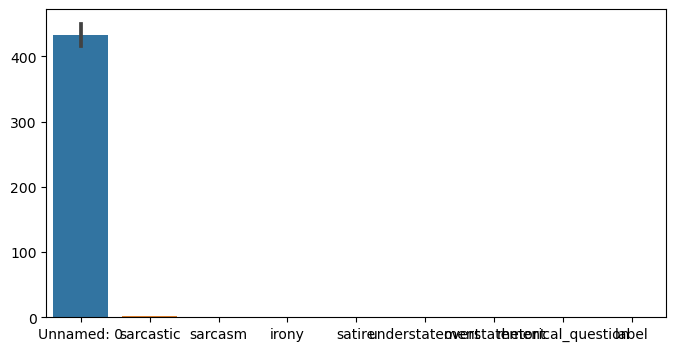

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,4))
sns.barplot(result)
plt.show()

In [83]:
result['label'].value_counts()

0    1884
1     147
5     110
2      65
4      50
3      11
Name: label, dtype: int64

In [61]:
import pandas as pd

# Assuming you have a DataFrame 'df' with columns 'text' and 'label'

# Filter the DataFrame to exclude rows with label zero
non_zero_df = result[result['label'].isin([1,2, 3, 4,5])]

# Duplicate the rows in the filtered DataFrame
duplicated_df = non_zero_df.sample(frac=1, replace=True)

# Concatenate the original DataFrame and duplicated DataFrame
result = pd.concat([result, duplicated_df], ignore_index=True)

# Print the final DataFrame with duplicated rows
result['label'].value_counts()


0    1878
3    1295
1    1194
2    1032
5     922
4     749
Name: label, dtype: int64

In [56]:
# Create the pandas DataFrame with column name is provided explicitly
df = pd.read_csv("/kaggle/input/sacsasm/tweetsclass3.txt", sep = " ", names=['text'])
df['label'] = 3
# df.reset_index(drop=True, inplace=True)
# result.reset_index(drop=True, inplace=True)
frames = [result , df]
result = pd.concat(frames,ignore_index=True, sort=False)
result.tail(10)

,text,label
2321,I accidentally discovered a hidden talent for painting. Just a small stroke of luck.,3
2322,I slightly underestimated the spiciness of that dish. My taste buds got a surprise.,3
2323,The weather was mildly unpredictable. Gave me a chance to test my improvisation skills.,3
2324,"I may have accidentally stayed up all night binge-watching a TV series. Time well spent, I suppose.",3
2325,The party was okay. We only danced like nobody was watching for a little while.,3
2326,I spotted a few shooting stars. Nature's way of reminding us to dream a little.,3
2327,I accidentally stumbled upon a beautiful park. A delightful oasis in the city.,3
2328,The traffic was mildly congested. Gave me time to enjoy some quality music.,3
2329,"I think I blinked and missed a spectacular sunset. But hey, there's always tomorrow.",3
2330,I had a somewhat productive day. Accomplished a few things on my never-ending to-do list.,3


In [9]:
print(os.environ["PYTORCH_CUDA_ALLOC_CONF"])

max_split_size_mb:516


In [57]:
result['label'].value_counts()

0    1878
1     147
5     110
3      81
2      65
4      50
Name: label, dtype: int64

In [11]:
pd.set_option('display.max_colwidth', None)
text_3 = result[result['label']==3]['text']
text_3.to_csv('/kaggle/working/class3.csv')


In [12]:
!pip install tweet-preprocessor

In [62]:
import preprocessor as p
p.set_options(p.OPT.URL,p.OPT.MENTION,p.OPT.NUMBER)

#forming a separate feature for cleaned tweets
for i,v in enumerate(result['text']):
    result.loc[i,'text_preprocessed'] = p.clean(v)
    
result.head()

,text,label,text_preprocessed
0,The only thing I got from college is a caffeine addiction,1,The only thing I got from college is a caffeine addiction
1,I love it when professors draw a big question mark next to my answer on an exam because I’m always like yeah I don’t either ¯\_(ツ)_/¯,0,I love it when professors draw a big question mark next to my answer on an exam because I’m always like yeah I don’t either ¯\_(ツ)_/¯
2,Remember the hundred emails from companies when Covid started getting real? I’ve gotten three in regards to support for protests. And only @SavageXFenty shared helpful links and actually said black lives matter... we love capitalism 🥰🙌🏼,1,Remember the hundred emails from companies when Covid started getting real? I’ve gotten three in regards to support for protests. And only shared helpful links and actually said black lives matter... we love capitalism 🥰🙌🏼
3,Today my pop-pop told me I was not “forced” to go to college 🙃 okay sure sureeee,0,Today my pop-pop told me I was not “forced” to go to college 🙃 okay sure sureeee
4,"@VolphanCarol @littlewhitty @mysticalmanatee I did too, and I also reported Cancun Cruz not worrying about the heartbeats of his constituents without electricity or heat when he fled to Mexico.",0,"I did too, and I also reported Cancun Cruz not worrying about the heartbeats of his constituents without electricity or heat when he fled to Mexico."


In [63]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, test_inputs, train_labels, test_labels = train_test_split(result['text_preprocessed'], result['label'], 
                                                            random_state=2018, test_size=0.1)

In [16]:
train_inputs.shape

(2097,)

In [17]:
train_labels.shape

(2097,)

In [18]:
test_inputs.shape

(234,)

In [19]:
test_labels.shape

(234,)

In [20]:
from transformers import BertTokenizer
PRETRAINED_LM = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True,model_max_length=512)
tokenizer

BertTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [21]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=512, padding='max_length',
                            return_attention_mask=True, truncation=True,  return_token_type_ids=False,return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [70]:
result['label'].value_counts()

0    1878
3    1295
1    1194
2    1032
5     922
4     749
Name: label, dtype: int64

3    2499
1    2200
2    2162
0    1878
4    1815
5    1810
Name: label, dtype: int64

In [26]:
result['label'].value_counts()

0    1878
1     147
5     110
3      81
2      65
4      50
Name: label, dtype: int64

In [64]:
train_input_ids, train_att_masks = encode(train_inputs.tolist())
test_input_ids, test_att_masks = encode(test_inputs.tolist())

In [ ]:
X_resampled

In [65]:
train_y = torch.LongTensor(train_labels.tolist())
test_y = torch.LongTensor(test_labels.tolist())
train_y.size(),test_y.size()

(torch.Size([6363]), torch.Size([707]))

In [ ]:
# test_y

In [66]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
N_labels = len(result.label.unique())
N_labels

In [ ]:
type(N_labels)

In [50]:
from transformers import BertForSequenceClassification
N_labels = len(result.label.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
for name, param in model.named_parameters():
    if 'classifier' not in name: # classifier layer
        param.requires_grad = False

In [ ]:
# Verify the frozen layers
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f'Parameter {name} is frozen.')

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [52]:
model = model.cuda()
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [53]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

EPOCHS = 10
# LEARNING_RATE = 2e-6

# optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

In [67]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask,labels = labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()


Epoch:  1


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Epoch:  2


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Epoch:  3


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Epoch:  4


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Epoch:  5


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Epoch:  6


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Epoch:  7


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Epoch:  8


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Epoch:  9


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Epoch:  10


Training:   0%|          | 0/398 [00:00<?, ?it/s]

In [68]:
model.eval()
test_pred = []
test_f1 = 0.0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask)
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [69]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report

labels = result.label.unique()
print("f1 score macro :",metrics.f1_score(test_y, test_pred, average = 'macro'))
print(classification_report(test_y, test_pred))

f1 score macro : 0.9914936455282356
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       199
           1       0.97      1.00      0.99       111
           2       1.00      1.00      1.00       117
           3       1.00      1.00      1.00       109
           4       1.00      1.00      1.00        72
           5       0.96      1.00      0.98        99

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707



In [ ]:
list(result.label.unique())

### Tried with Balanced CrossEntroyLoss

In [ ]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=result['label'].values)

# Convert class weights to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


In [ ]:
class_weights_tensor

In [ ]:
np.unique(train_labels)

In [ ]:
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        optimizer.zero_grad()
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask,labels = labels)
        loss_func = nn.CrossEntropyLoss(weight=class_weights_tensor,reduction='mean')
        # Get the logits from the model's output
        logits = output.logits
        
        # Compute the loss
        
        loss = loss_func(logits, labels)
        
        loss.backward()
        
#         if _%16==0:
#             print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        



In [ ]:
model.eval()
test_pred = []
test_f1 = 0.0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask)
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report
print("f1 score macro :",metrics.f1_score(test_y, test_pred, average = 'macro'))
print(classification_report(test_y, test_pred))

## Tried with Folcal Loss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.criterion(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss

focal_loss = FocalLoss()

In [ ]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask,labels = labels)

        # Get the logits from the model's output
        logits = output.logits
        loss = focal_loss(logits, labels)
        
        loss.backward()

        model.zero_grad()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()


In [ ]:
model.eval()
test_pred = []
test_f1 = 0.0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask)
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

In [ ]:
print("f1 score macro :",metrics.f1_score(test_y, test_pred, average = 'macro'))
print(classification_report(test_y, test_pred))

## Bertweet experiment

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [ ]:
bertweet_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base") #bertweet-large
bertweet_model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=6)


In [ ]:
for name, param in bertweet_model.named_parameters():
    if 'classifier' not in name: # classifier layer
        param.requires_grad = False

In [ ]:
# Verify the frozen layers
for name, param in bertweet_model.named_parameters():
    if not param.requires_grad:
        print(f'Parameter {name} is frozen.')

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = bertweet_tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True,  return_token_type_ids=False,return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [ ]:
train_input_ids_tweet, train_att_masks_tweet = encode(train_inputs.tolist())
test_input_ids_tweet, test_att_masks_tweet = encode(test_inputs.tolist())

In [ ]:
train_y = torch.LongTensor(train_labels.tolist())
test_y = torch.LongTensor(test_labels.tolist())
train_y.size(),test_y.size()

In [ ]:
test_labels.unique()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset_tweet = TensorDataset(train_input_ids_tweet, train_att_masks_tweet, train_y)
train_sampler_tweet = RandomSampler(train_dataset_tweet)
train_dataloader_tweet = DataLoader(train_dataset_tweet, sampler=train_sampler_tweet, batch_size=BATCH_SIZE)

test_dataset_tweet = TensorDataset(test_input_ids_tweet, test_att_masks_tweet, test_y)
test_sampler_tweet = SequentialSampler(test_dataset_tweet)
test_dataloader_tweet = DataLoader(test_dataset_tweet, sampler=test_sampler_tweet, batch_size=BATCH_SIZE)

In [ ]:
bertweet_model = bertweet_model.cuda()
bertweet_model

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in bertweet_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in bertweet_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

EPOCHS = 10
# LEARNING_RATE = 2e-6

# optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader_tweet)*EPOCHS )

In [ ]:
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    bertweet_model.train()
    train_loss = 0
    total_samples = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader_tweet,desc='Training')):
        optimizer.zero_grad()
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = bertweet_model(input_ids = input_ids, attention_mask=att_mask,labels = labels)
        loss_func = nn.CrossEntropyLoss(weight=class_weights_tensor,reduction='mean')
        # Get the logits from the model's output
        logits = output.logits
        
        # Compute the loss
        
        loss = loss_func(logits, labels)
        train_loss += loss.item() * input_ids.size(0)
        total_samples += input_ids.size(0)
        loss.backward()
        del loss

        clip_grad_norm_(parameters=bertweet_model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
    epoch_loss = train_loss / total_samples
    print(f"Training Loss: {epoch_loss:.4f}")

In [ ]:
bertweet_model.eval()
test_pred = []
test_f1 = 0.0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader_tweet)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = bertweet_model(input_ids = input_ids, attention_mask=att_mask)
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report

print("f1 score macro :",metrics.f1_score(test_y, test_pred, average = 'macro'))
print(classification_report(test_y, test_pred))

##  LSTM experiment with weighted crossentropy

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Embedding, LSTM
from keras.layers.core import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.utils import pad_sequences,to_categorical

In [ ]:
# create a tokenizer
tokenizer = Tokenizer()
# fit the tokenizer in the train text
tokenizer.fit_on_texts(train_inputs)

In [ ]:
# get max length of the train data
max_length = max([len(s.split()) for s in train_inputs])

# pad sequences in x_train data set to the max length
x_train = pad_sequences(tokenizer.texts_to_sequences(train_inputs),
                        maxlen = max_length)
# pad sequences in x_test data set to the max length
x_test = pad_sequences(tokenizer.texts_to_sequences(test_inputs),
                       maxlen = max_length)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", train_labels.shape)

print("y_train shape:", x_test.shape)
print("y_test shape:", test_labels.shape)

# train_inputs, test_inputs, train_labels, test_labels

In [ ]:
from numpy import zeros
# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r',encoding="utf-8")
    lines = file.readlines()
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, embedding_dim))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

# contains the index for each word
vocab = tokenizer.word_index
# total number of words in our vocabulary, plus one for unknown words
vocab_size = len(tokenizer.word_index) + 1
# embedding dimensions
embedding_dim = 200

# load embedding from file
raw_embedding = load_embedding('/kaggle/input/glove/glove.twitter.27B.25d.txt')
# get vectors in the right order
embedding_matrix = get_weight_matrix(raw_embedding, vocab)

print("Vocab size: ", vocab_size)
print("Max text length: ", max_length)
print("Embedding dim: ", embedding_dim)

In [ ]:
embedding_layer = Embedding(vocab_size, 
                            embedding_dim, 
                            weights = [embedding_matrix], 
                            input_length = max_length, 
                            trainable = False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units=128, dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(units=6, activation='softmax'))
print(model.summary())

In [ ]:
x_train.shape

In [ ]:
train_labels.shape

In [ ]:
train_y_one_hot = to_categorical(train_labels, 6)
test_y_one_hot = to_categorical(test_labels, 6)

In [ ]:

BATCH_SIZE = 16
EPOCHS = 200

model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])

# callbacks
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.1,
                              min_lr = 0.01)
# train_inputs, test_inputs, train_labels, test_labels
# train model
history = model.fit(x_train, train_y_one_hot, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    validation_split = 0.1, verbose = 1, callbacks = [reduce_lr])

In [ ]:
from sklearn.metrics import classification_report

model_predictions = model.predict(x_test, batch_size = BATCH_SIZE, verbose = 1)
predicted_labels = np.argmax(model_predictions, axis=1)

print(classification_report(test_labels, predicted_labels))

In [ ]:
test_labels

In [ ]:
score = model.evaluate(x_test, test_y_one_hot, batch_size = BATCH_SIZE)
print("Test loss:", score[0])
print("Test accuracy:", score[1])